# TF‑IDF + Logistic Regression 情感分类 Baseline（传统特征）
> 目标：用“传统特征工程 + 线性分类器”完成第一个 NLP 文本分类模型，并输出一张 **baseline 分类实验结果表**（不只看 accuracy）。

本 Notebook 默认使用 **IMDb 二分类情感数据集**（英文影评，正/负）。  
- 数据集：Hugging Face `stanfordnlp/imdb`（训练 25,000 / 测试 25,000） citeturn0search0  
- 任务：二分类（positive / negative）
- 特征：TF‑IDF（词/字 n‑gram）
- 分类器：Logistic Regression（逻辑回归）

---

## 你需要掌握的核心点（面试官视角）
### 1) 为什么“特征工程”重要？
在传统机器学习里，**模型能力上限**很大程度上由“特征表示”决定。  
- **同一个分类器（LR）**，TF‑IDF + 合理的 n‑gram、min_df/max_df、正则化强度，性能可以差很多。  
- **同一套特征（TF‑IDF）**，换不同线性分类器（LR/LinearSVM）也会有差异，但通常不如“特征”带来的增益稳定。

你在面试里要能讲清楚一句话：  
> *“线性模型的决策边界简单，但在高维稀疏的 TF‑IDF 空间里，合适的特征工程能把文本的判别信号显式化，让线性模型也能很好地分割正负情感。”*

### 2) 文本分类 Pipeline（你必须能顺口讲出来）
数据准备 → 文本清洗（可选） → 划分训练/验证/测试 → 特征抽取（TF‑IDF） → 训练分类器（LR）  
→ 调参（C、class_weight、ngram_range、min_df、max_df） → 指标评估（Accuracy/Precision/Recall/F1/ROC‑AUC）  
→ 误差分析（错分样本、混淆矩阵、阈值） → 迭代改进

---

## 评估指标

TP(true positive)       预测为正、实际也为正

FP(false positive)      预测为正，实际为负

TN(true negative)       预测为负，实际也为负

FN(false negative)      预测为负，实际为正

- **Accuracy**：$$\text { Accuracy }=\frac{T P+T N}{T P+F P+F N+T N}$$
总体预测对的比例。类不平衡时容易“看起来很高但没用”。

类不平衡是指正负样本比例严重不平均，比如99%是负类，1%是正类。

- **Precision（精确率）**：$$\text { Precision }=\frac{T P}{T P+F P}$$
预测为正类里，有多少是真的正类。*关注“别把负的当成正的”。*

- **Recall（召回率）**：$$\text { Recall }=\frac{T P}{T P+F N}$$
真实正类里，有多少被你找出来了。*关注“别漏掉正的”。*

- **F1**：$$F 1=\frac{2 \cdot \text { Precision } \text { ⋅ } \text { Recall }}{\text { Precision }+ \text { Recall }}$$
Precision 和 Recall，谁低，F1 就跟着谁走。Precision 和 Recall 的调和平均（更惩罚短板）。想要两者兼顾时用。

- **ROC‑AUC**：真正率=recall（纵轴）：$T P R=\frac{T P}{T P+F N}$, 假正率（横轴）：$F P R=\frac{F P}{F P+T N}$

AUC的定义：$$A U C=\int_{0}^{1} T P R(F P R) d(F P R)$$
含义：ROC曲线下的面积

ROC-AUC 等于“随机选一个正样本和一个负样本，模型把正样本排在前面的概率”，数学上是 ROC 曲线下的面积，衡量的是模型的整体排序能力，与具体分类阈值无关。当你要讨论“阈值怎么选”或类不平衡时特别有用。

跑完后，你需要能回答：
1) 为什么 Accuracy 可能误导？ 

例如正类只占 1%，模型全预测为负类，Accuracy=99%，但一个正类都没找出来（Recall=0）。把“误报”和“漏报”当成同等错误，但很多业务里两者代价完全不同。Accuracy 只适合类别均衡、错误代价相近的场景，否则容易“看起来很高但没用”。
2) 业务更在意“误报”还是“漏报”，对应哪个指标？  

业务怕误报就看 Precision，怕漏报就看 Recall。
3) ROC‑AUC 和 F1 的区别是什么？

ROC-AUC 衡量的是模型的整体排序能力、与阈值无关，而 F1 衡量的是某个阈值下 Precision 与 Recall 的折中。



## 逻辑回归（Logistic Regression）
>逻辑回归（Logistic Regression）是一种经典的二分类模型,逻辑回归 = 用线性模型算一个分数，再把这个分数映射成“属于正类的概率”的分类模型。
### 1）核心机制
1.先做一件“线性回归”的事
给定输入特征x（比如tf-idf向量），模型先算：$$z=w^{\top} x+b$$
w: 权重（每一个词的权重）

b：偏置

z：一个任意实数（可能很大、很小、正、负）

2.再用一个「Sigmoid 函数」压成概率$$\sigma(z)=\frac{1}{1+e^{-z}}$$
输出范围(0,1)

可以解释为：“是正类的概率”
$$P(y=1 \mid x)=\sigma\left(w^{\top} x+b\right)$$

3.最后用阈值做分类

例如阈值是0.5：
- p≥0.5 → 预测为正类
- p<0.5 → 预测为负类

### 2）逻辑回归到底学到了什么？
在这个tf-idf + 逻辑回归的场景中：

每一个词 / n-gram都有一个权重

权重的作用：
- 正 → 倾向正类
- 负 → 倾向负类
- 绝对值大 → 影响大

所以它非常可解释，可以用来知道哪些词在“推动”模型做判断。

### 总结
>逻辑回归是一种二分类模型，它先对特征做线性加权，再通过 Sigmoid 函数输出属于正类的概率，并通过阈值完成分类；虽然名字叫回归，但实际主要用于分类，尤其适合高维稀疏的文本特征。

In [ ]:
# 如果你是第一次运行：建议先安装依赖
# （在本地/Colab/服务器上运行。公司面试通常不考你“装库”，但你要会。）
# !pip -q install datasets scikit-learn pandas numpy matplotlib


## 1. 加载数据集（IMDb）

用 TF-IDF 将文本转成稀疏向量，并且只在训练集上学习词表和 IDF，再用同一套规则转换验证集和测试集，从而避免数据泄漏，为后续模型训练做准备。

In [2]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("stanfordnlp/imdb") 
train_ds = ds["train"]
test_ds = ds["test"]

# 转成 DataFrame 方便操作
train_df = pd.DataFrame({"text": train_ds["text"], "label": train_ds["label"]})
test_df  = pd.DataFrame({"text": test_ds["text"],  "label": test_ds["label"]})

# 标签：0=negative, 1=positive（IMDb 官方约定）
train_df["label"].value_counts().rename(index={0:"neg",1:"pos"})


d:\Anaconda_envs\envs\pytorch2.3.1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


label
neg    12500
pos    12500
Name: count, dtype: int64

## 2. 划分验证集（从训练集切一部分）

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df["text"],
    train_df["label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["label"]
)

len(X_train), len(X_valid), len(test_df)


(20000, 5000, 25000)

## 3. 特征抽取：TF‑IDF（关键：n‑gram & 过滤阈值）
用 TF-IDF 把文本转成向量，用训练集“学习词表和权重”，再用同一套规则去转换验证集和测试集。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# baseline 配置：词级 TF-IDF + 1~2gram
# 实验：ngram_range、min_df、max_df、sublinear_tf 等对结果的影响
vectorizer = TfidfVectorizer(
    lowercase=True,             #全转成小写
    stop_words="english",       #去掉英文停用词
    ngram_range=(1, 2),         #1-gram + 2-gram
    min_df=2,                   #去掉只在一个文档中出现的噪声词
    max_df=0.95,                #去掉出现在95%文档的词
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf  = vectorizer.transform(test_df["text"])

X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape


((20000, 250103), (5000, 250103), (25000, 250103))

## 4. 训练分类器：Logistic Regression

>用逻辑回归这个线性模型，在tf-idf高维稀疏特征上学习一个分类器
流程：
- 1.X_train_tfidf: 文本 -> 数值向量
- 2.y_train: 真是标签
- 3.clf.fit(...): 学习一组线性权重 + 偏置

最终模型学到：$P(y=1 \mid x)=\sigma\left(w^{\top} x+b\right)$

In [6]:
from sklearn.linear_model import LogisticRegression

# 线性模型的核心：正则化强度 C
# 你后面需要实验：不同 C 对过拟合/欠拟合的影响
clf = LogisticRegression(
    max_iter=2000,
    C=1.0,               # c=1/λ, λ是正则化强度，c越大正则化越弱
    solver="liblinear",  # 对稀疏高维特征稳定
)

clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=2000, solver='liblinear')

## 5. 评估：Accuracy/Precision/Recall/F1/ROC‑AUC + 混淆矩阵

用模型输出的概率 → 设定阈值 → 得到预测标签 → 计算多种分类指标，分别评估验证集和测试集。

In [7]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report
)

def evaluate_binary(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    auc = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)#混淆矩阵，结果是[[TN,FP],[FN,TP]]
    return {
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
    }

# valid
valid_proba = clf.predict_proba(X_valid_tfidf)[:, 1]
valid_pred  = (valid_proba >= 0.5).astype(int)
valid_metrics = evaluate_binary(y_valid, valid_pred, valid_proba)

# test
test_proba = clf.predict_proba(X_test_tfidf)[:, 1]
test_pred  = (test_proba >= 0.5).astype(int)
test_metrics = evaluate_binary(test_df["label"], test_pred, test_proba)

valid_metrics, test_metrics


({'accuracy': 0.8892,
  'precision': 0.8765479876160991,
  'recall': 0.906,
  'f1': 0.8910306845003934,
  'roc_auc': 0.9554185599999999,
  'confusion_matrix': array([[2181,  319],
         [ 235, 2265]], dtype=int64)},
 {'accuracy': 0.87492,
  'precision': 0.8731586909785811,
  'recall': 0.87728,
  'f1': 0.8752144937946447,
  'roc_auc': 0.9479500992000001,
  'confusion_matrix': array([[10907,  1593],
         [ 1534, 10966]], dtype=int64)})

## 6. 必须产出：baseline 分类实验结果表（多指标）

把验证集和测试集的评估指标整理成一张表格，并统一数值显示格式，方便对比模型在不同数据划分上的表现，用于分析和汇报结果。

In [8]:
import pandas as pd

def metrics_to_row(name, m):
    return {
        "split": name,
        "accuracy": m["accuracy"],
        "precision": m["precision"],
        "recall": m["recall"],
        "f1": m["f1"],
        "roc_auc": m["roc_auc"],
    }

result_table = pd.DataFrame([
    metrics_to_row("valid", valid_metrics),
    metrics_to_row("test",  test_metrics),
])

# 统一小数显示
result_table.style.format({
    "accuracy": "{:.4f}",
    "precision": "{:.4f}",
    "recall": "{:.4f}",
    "f1": "{:.4f}",
    "roc_auc": "{:.4f}",
})


,split,accuracy,precision,recall,f1,roc_auc
0,valid,0.8892,0.8765,0.9060,0.8910,0.9554
1,test,0.8749,0.8732,0.8773,0.8752,0.9480


## 7. 误差分析：看混淆矩阵 + 抽样查看错分样本

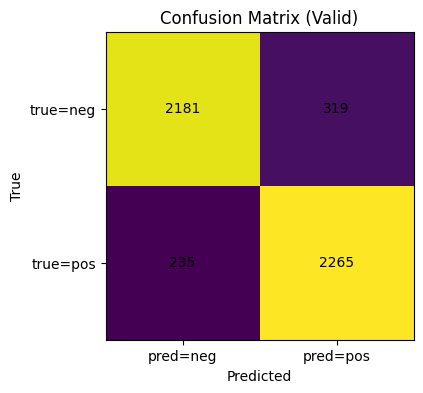

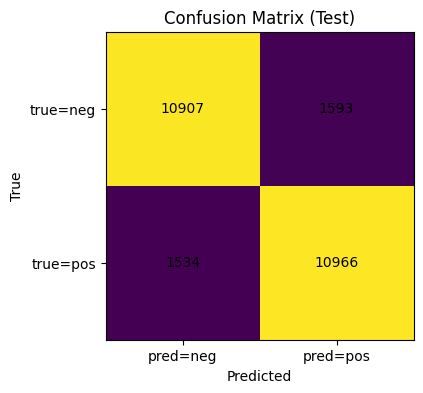

In [9]:
import matplotlib.pyplot as plt

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    #把矩阵当成图像显示
    plt.xticks([0,1], ["pred=neg","pred=pos"])
    plt.yticks([0,1], ["true=neg","true=pos"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")#i->行->y轴，j->列-x轴
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(valid_metrics["confusion_matrix"], "Confusion Matrix (Valid)")
plot_confusion(test_metrics["confusion_matrix"], "Confusion Matrix (Test)")


从验证集中找出预测错误的样本，优先挑出模型最不确定但仍然预测错的句子，用来分析模型到底“错在哪类文本上”。

In [12]:
# 抽样看错分样本：你要能说清“错在哪些类型的句子上”
valid_df = pd.DataFrame({"text": X_valid.values, "y_true": y_valid.values, "proba": valid_proba})
valid_df["y_pred"] = (valid_df["proba"] >= 0.5).astype(int)
errors = valid_df[valid_df["y_true"] != valid_df["y_pred"]].copy()

#|proba - 0.5|，0.5 = 分类边界
#距离越近 → 模型越犹豫；距离越远 → 模型越自信
errors["abs_margin"] = np.abs(errors["proba"] - 0.5)  # 越小越“不确定”
errors.sort_values("abs_margin").head(10)


,text,y_true,proba,y_pred,abs_margin
1961,Jude Law gives his all in this beautifully fil...,0,0.500106,1,0.000106
2535,"So, back when Herbie made his first appearance...",0,0.500400,1,0.000400
2962,"A typical 70s Italian coming of age film, orig...",0,0.500495,1,0.000495
3058,The '80's were not very kind to one-time major...,0,0.500743,1,0.000743
2293,When I heard Patrick Swayze was finally return...,1,0.499014,0,0.000986
2891,The Unborn tells the tale of a married couple ...,1,0.498655,0,0.001345
4344,Watching Cliffhanger makes me nostalgic for th...,1,0.498365,0,0.001635
2325,13 days to Glory tells the traditional tale wi...,1,0.498361,0,0.001639
2483,First To Die 2003<br /><br />I'll admit my mis...,0,0.501763,1,0.001763
3069,This one came out during the Western genre’s l...,0,0.501910,1,0.001910


## 8. 你需要给出的实验分析（写法模板）
把下面几段写进你的实验报告/面试回答里（根据你跑出来的结果改数字即可）：

1) **数据**：IMDb 是二分类情感任务，训练/测试各 25k，标签相对均衡。
2) **baseline**：TF‑IDF(1-2gram) + LR(C=1.0) 在 valid/test 上获得 (Accuracy≈0.8892 / 0.8749，F1≈0.8910 / 0.8752，AUC≈0.9554 / 0.9480)。  
3) **指标解读**：  
   - 如果 Accuracy 和 F1 差距大：通常意味着某一类更难，或阈值 0.5 不合适。  
   - AUC 高但 F1 一般：说明排序能力不错，但固定阈值下 precision/recall 不平衡，可能需要调阈值或 class_weight。  
4) **误差类型**（你需要从错分样本里总结）：  
   - 否定词、反讽（“not bad”、“so good it hurts”）  
   - 弱情感 / 叙述型文本（情感信号接近中性），如"A typical 70s Italian coming of age film…"  
   - 依赖长距离语义（传统 n‑gram 捕获不到）,如"When I heard Patrick Swayze was finally returning…"  
5) **下一步提升方向**（要可操作、能做对比实验）：  
   - 调 `ngram_range`：1-3gram 或加字符级 n‑gram（对拼写/形态更鲁棒）  
   - 调 `C` 和 `class_weight`：观察 precision/recall 的 trade-off  
   - 试 LinearSVM / SGDClassifier（同特征，不同线性分类器）  
   - 更严格的文本清洗（但注意：过度清洗可能伤害性能）
  
> “你为什么选 TF‑IDF？” 

因为 IMDb 是典型的高维稀疏文本分类任务，TF-IDF 能高效捕捉区分性词语，同时保持模型可解释、训练成本低，适合作为 strong baseline。
>“为什么 LR 适合高维稀疏？” 

Logistic Regression 对高维稀疏特征非常鲁棒，优化问题是凸的，结合 L2 正则可以有效防止过拟合，是文本分类的经典强基线。
>“ROC‑AUC 高但 F1 低你怎么解释？”  

Logistic Regression 对高维稀疏特征非常鲁棒，优化问题是凸的，结合 L2 正则可以有效防止过拟合，是文本分类的经典强基线。